In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import umap
from sklearn.manifold import TSNE

2024-09-04 12:50:53.842432: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 12:50:53.992999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 12:50:53.993106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 12:50:54.020472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 12:50:54.084674: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
from TRAIL24.data.preprocess import *
from TRAIL24.data.cluster import *

path_to_folder = '/home/vincent/Documents/Multitel/Projects/TRAIL_workshop_Portugal/project/'

### Read the data and form the dataset

In [ ]:
file_path3 = path_to_folder + 'TRAIL24/dataset_electricity/residential_all.pkl'
df3 = pd.read_pickle(file_path3)
df3["ID"] = df3["ID"].astype("category")
df3["time_code"] = df3["time_code"].astype("uint16")

df3 = df3.set_index(["date_time","ID"])
df3 = df3.groupby('ID', group_keys=False, observed=True).apply(resample_building_data)
df3=df3.reset_index(level=['ID',"date_time"])

# Generate the range of date_time values
start_time = pd.Timestamp('2009-07-14 00:00:00')
end_time = pd.Timestamp('2011-01-01 00:00:00')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')

# Pivot the dataset
df_pivoted = df3.pivot(index='ID', columns='date_time', values='consumption').reset_index()

# Ensure columns are sorted by date_time
# df_pivoted = df_pivoted.sort_index(axis=1)

# Optional: Rename the columns to make them more readable
df_pivoted.columns.name = None
df_pivoted.columns = ['ID'] + [date.strftime('%Y-%m-%d %H:%M:%S') for date in date_range]

### Compute summary statistics

In [ ]:
aggregation_results = []

for i, row in tqdm(df_pivoted.iterrows()):
    building_data = row[1:].astype(float)  # Skip the first column (ID)
    building_series = pd.Series(building_data.values, index=pd.date_range(start='2009-07-14 00:00:00', periods=len(building_data), freq='h'))
    
    # Perform the aggregations
    #stats = weekly_monthly_statistics(building_series)
    
    stats = np.concatenate([compute_statistics(building_series)])
    
    # Combine all the aggregation results for the current building
    aggregation_results.append(stats)
    
    
# Convert the aggregation results to a DataFrame
df_aggregations = pd.DataFrame(aggregation_results)#, columns=aggregation_columns)


0it [00:00, ?it/s]

### Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_aggregations.fillna(0))

indexes = [0,1,2,3,4,5,6,7,8,9,10]
data_scaled_bis = data_scaled[:,indexes]

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
labels = spectral.fit_predict(data_scaled_bis)

### Plot clustering results using UMAP and t-SNE

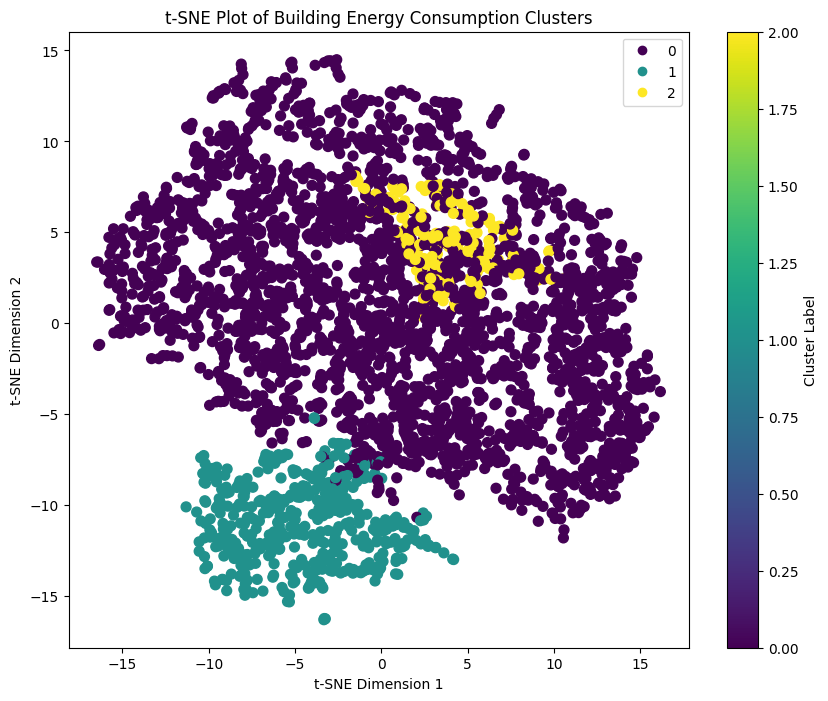

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=3, perplexity=30, learning_rate=500 , n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_scaled_bis)

# Create a DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    't-SNE3': tsne_results[:, 2],
    'Cluster': labels
})

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Cluster'], cmap='viridis', s=50)
plt.title('t-SNE Plot of Building Energy Consumption Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
plt.colorbar(scatter, label='Cluster Label')
plt.show()


import plotly.express as px

# Plotting with Plotly
plt.figure(figsize=(15,15))
fig = px.scatter_3d(tsne_df, x='t-SNE1', y='t-SNE2', z='t-SNE3', color='Cluster',
                    labels={'t-SNE1': 't-SNE Dimension 1', 't-SNE2': 't-SNE Dimension 2', 't-SNE3': 't-SNE Dimension 3'},
                    color_continuous_scale='Viridis')
fig.show()

/home/vincent/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/vincent/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



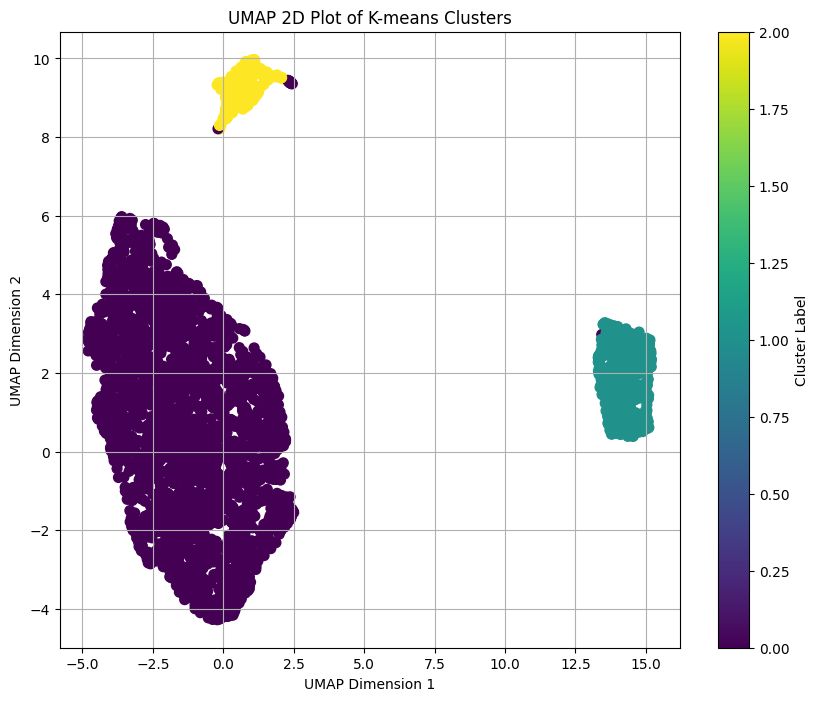

In [ ]:
# Apply UMAP for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_results_2d = umap_2d.fit_transform(data_scaled_bis)

# Apply UMAP for 3D visualization
umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_results_3d = umap_3d.fit_transform(data_scaled_bis)

# Create DataFrames with UMAP results and K-means cluster labels
umap_df_2d = pd.DataFrame({
    'UMAP1': umap_results_2d[:, 0],
    'UMAP2': umap_results_2d[:, 1],
    'Cluster': labels
})

umap_df_3d = pd.DataFrame({
    'UMAP1': umap_results_3d[:, 0],
    'UMAP2': umap_results_3d[:, 1],
    'UMAP3': umap_results_3d[:, 2],
    'Cluster': labels
})

# 2D Plotting with Matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_df_2d['UMAP1'], umap_df_2d['UMAP2'], c=umap_df_2d['Cluster'], cmap='viridis', s=50)
plt.title('UMAP 2D Plot of K-means Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

# 3D Plotting with Plotly
fig = px.scatter_3d(umap_df_3d, x='UMAP1', y='UMAP2', z='UMAP3', color='Cluster',
                    title='UMAP 3D projection of the data',
                    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2', 'UMAP3': 'UMAP Dimension 3'},
                    color_continuous_scale='Viridis')
fig.show()

### Verify clustering by checking the timeseries

Text(0.5, 0, 'Time (days)')

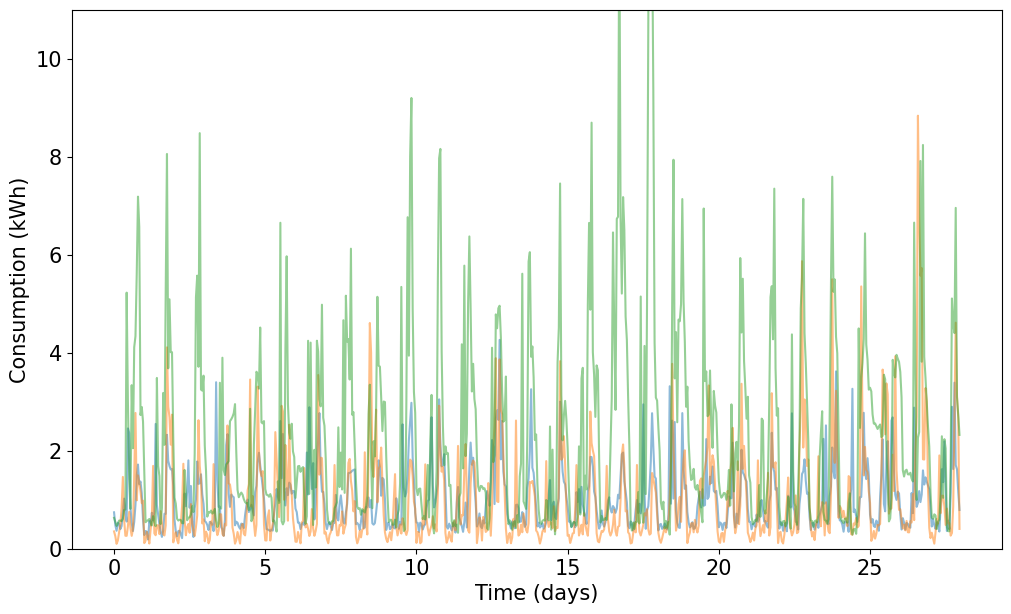

In [ ]:
# First cluster
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

start = 10
start_week = 168*15
weeklength = 168*4

hours = np.arange(weeklength)
days = hours/24

#plt.figure(figsize=(12,7))
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(0.0, 0.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(-2.5, 2.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(-2.5, -2.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.ylim([0,11])

plt.figure(figsize=(12,7))
plt.plot(days, df_pivoted.loc[cluster_0[7]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_0[11]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_0[111]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.ylim([0,11])
plt.ylabel('Consumption (kWh)')
plt.xlabel('Time (days)')




Text(0.5, 0, 'Time (days)')

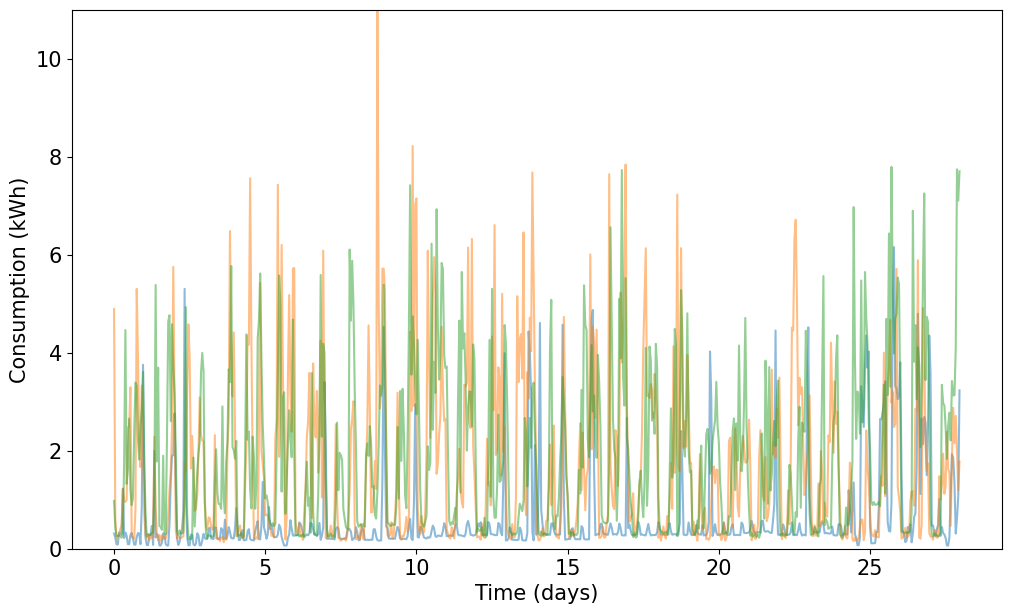

In [ ]:
# Second cluster

start = 10
start_week = 168*22
weeklength = 168*4

hours = np.arange(weeklength)
days = hours/24

#plt.figure(figsize=(12,7))
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(14.0, 3.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(15.0, 2.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(13.5, 1.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.ylim([0,11])

plt.figure(figsize=(12,7))
plt.plot(days, df_pivoted.loc[cluster_1[65]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_1[16]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_1[25]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.ylim([0,11])
plt.ylabel('Consumption (kWh)')
plt.xlabel('Time (days)')




Text(0.5, 0, 'Time (days)')

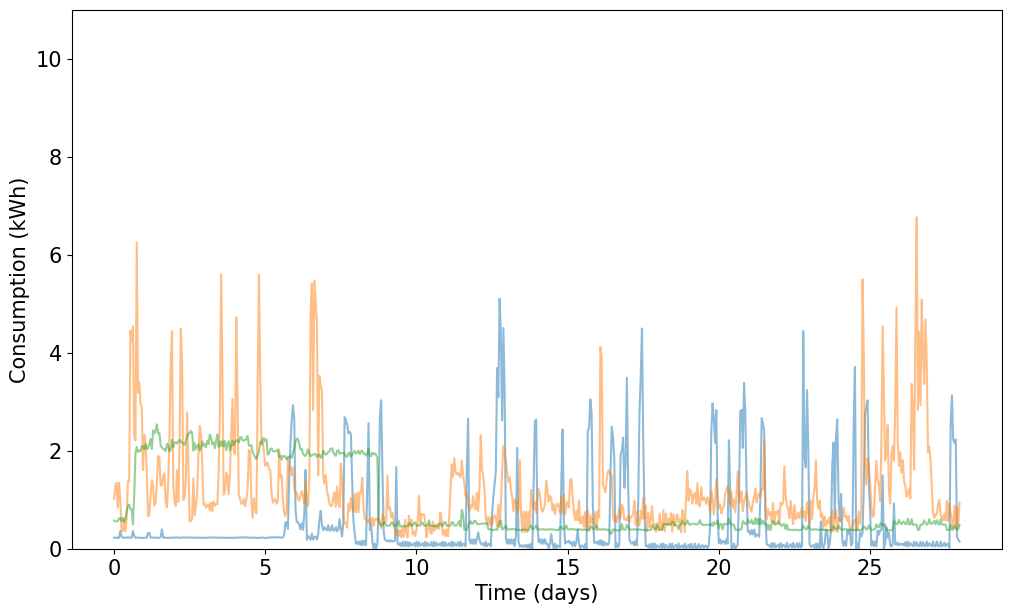

In [ ]:
# Third cluster

start = 10
start_week = 168*25
weeklength = 168*4

hours = np.arange(weeklength)
days = hours/24

#plt.figure(figsize=(12,7))
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(0.0, 9.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(1.0, 9.5, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.plot(df_pivoted.loc[revert_umap_projection_2D(0.25, 9.0, umap_df_2d)][1+start_week:start_week+weeklength+1].values, alpha=0.5)
#plt.ylim([0,11])

plt.figure(figsize=(12,7))
plt.plot(days, df_pivoted.loc[cluster_2[7]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_2[10]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.plot(days, df_pivoted.loc[cluster_2[111]][1+start_week:start_week+weeklength+1].values, alpha=0.5)
plt.ylim([0,11])
plt.ylabel('Consumption (kWh)')
plt.xlabel('Time (days)')



### Save the clusters

In [ ]:
# Get the rows of the initial dataframe for each cluster

umap_df_2d = pd.DataFrame({
    'UMAP1': umap_results_2d[:, 0],
    'UMAP2': umap_results_2d[:, 1],
    'Cluster': labels
})


cluster_0 = []
cluster_1 = []
cluster_2 = []


for i,j,k in tqdm(zip(umap_results_2d[:,0], umap_results_2d[:,1], labels)):
    
    index = revert_umap_projection_2D(i, j, umap_df_2d)
    
    if(k==0):
        cluster_0.append(index)
        
    elif(k==1):
        cluster_1.append(index)
        
    else:
        cluster_2.append(index)

        
# Print the number of samples for each cluster
print(len(cluster_0), len(cluster_1), len(cluster_2))

0it [00:00, ?it/s]

2973 457 209


In [ ]:

np.save(path_to_folder+'TRAIL24/centralized experiments/cluster_0.npy', np.array(cluster_0))

np.save(path_to_folder+'TRAIL24/centralized experiments/cluster_1.npy', np.array(cluster_1))

np.save(path_to_folder+'TRAIL24/centralized experiments/cluster_2.npy', np.array(cluster_2))


### Feature importance analysis using XGBoost classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled_bis, labels, test_size=0.2, random_state=25)

model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
#model = XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9959


Text(0.5, 1.0, 'Feature Importance')

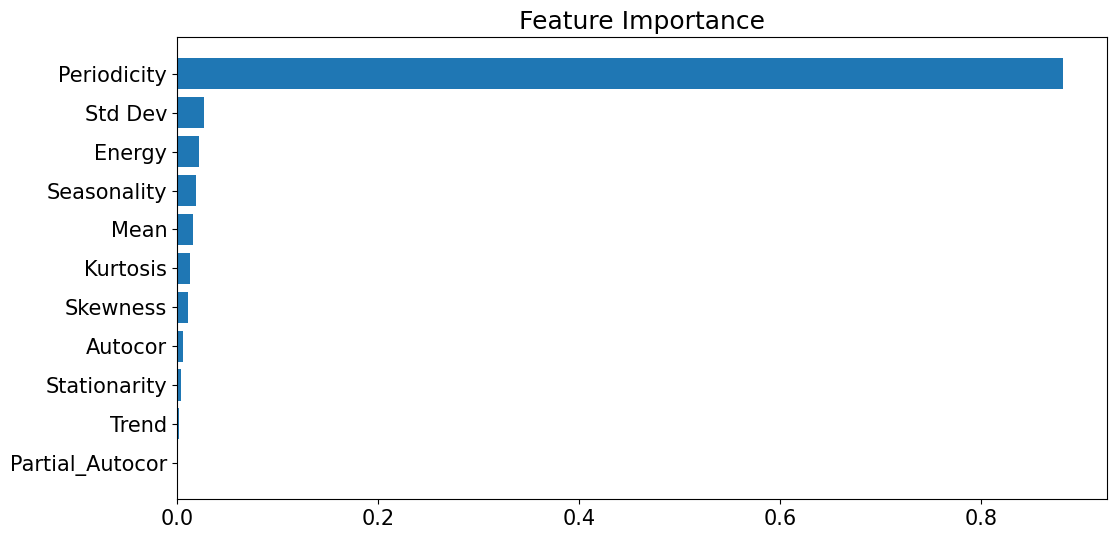

In [ ]:
labels_plots = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'Energy', 'Periodicity', 
                'Trend', 'Seasonality', 'Stationarity', 'Autocor', 'Partial_Autocor']

labels_plots_bis = np.array(labels_plots)[indexes]


feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(labels_plots_bis)[sorted_idx])
plt.title('Feature Importance')
